# Main script to calculate wind direction relationship from fire to patient

Modules: N/A <br>
Author: Jordan Meyer <br>
Email: jordan.meyer@berkeley.edu <br>
Date created: Feb 18, 2023 <br>

**Citations (data sources)**

``How to compute wind speed and direction:``

6. https://stackoverflow.com/questions/21484558/how-to-calculate-wind-direction-from-u-and-v-wind-components-in-r
7. https://github.com/blaylockbk/Ute_WRF/blob/master/functions/wind_calcs.py

``Wind speed and direction intuition:``

8. http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv
9. https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/intro-to-coordinate-reference-systems-python/

``To create maps of this wind data:``

and also used to provide intuition for winddir and windspeed

10. https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20calculate%20and%20plot%20wind%20speed%20using%20MERRA-2%20wind%20component%20data%20using%20Python


**Citations (persons)**
1. Cornelia Ilin 

**Preferred environment**
1. Code written in Jupyter Notebooks

### Step 1: Import packages

In [1]:
import pandas as pd
import numpy as np
import netCDF4 as ncdf
import os
from datetime import date, timedelta
from math import pi
import fiona

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# geography
import geopandas as gpd
import osmnx as ox
import shapely
from shapely.geometry import Point
import contextily as ctx 

#Moved from sklearn.neighbors to sklearn.metrics following their package change
import sklearn.metrics
dist = sklearn.metrics.DistanceMetric.get_metric(
    'haversine'
)

# ignore warnings
import warnings
warnings.filterwarnings(
    'ignore'
)


### Step 2: Define working directories

In [2]:
# in_dir_zip_shapes = 'C:/Users/cilin/Research/CA_hospitals/Input/raw_data/census_geo/shapefiles_zcta/'
# in_dir = 'C:/Users/cilin/Research/CA_hospitals/Input/raw_data/winds/'
# in_health = 'C:/Users/cilin/Research/CA_hospitals/Input/final_data/health/'
# out_dir = 'C:/Users/cilin/Research/CA_hospitals/Input/final_data/winds/'

#Local directories on my machine (not gdrive)
in_dir_zip_shapes = 'tl_2010_06_zcta510/'
in_dir = 'wind/ca only/'
in_health = 'health/'
out_dir = 'wind/clean/'

### Step 3: Define functions

### Step 4: Read data

``wind``

In [158]:
df = pd.read_csv("clean/all_years_wind_data.csv",index_col=0)

df.head()

,Unnamed: 0,lat,lon,ZCTA10,u,v,wdir,wspd,year_month,year,month
0,0,37.465,-117.936,89010,0.992558,0.124684,7.159901,1.000358,200601,2006,1
1,1,35.396,-116.322,89019,0.088867,-0.147450,301.077087,0.172160,200601,2006,1
2,2,36.161,-116.139,89060,-0.319009,-0.046086,188.220367,0.322321,200601,2006,1
3,3,35.957,-115.897,89061,-0.106072,-0.459862,257.011322,0.471937,200601,2006,1
4,4,39.520,-120.032,89439,0.707161,0.798291,48.464073,1.066463,200601,2006,1


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,627072.0,9797.500000,5656.882441,0.000000,4898.750000,9797.500000,14696.250000,19595.000000
lat,627072.0,36.396247,2.427053,32.534000,34.054000,36.658000,38.289000,41.999000
lon,627072.0,-119.916291,2.150673,-124.400000,-121.870000,-120.069000,-118.092000,-114.227000
ZCTA10,627072.0,93654.382119,1824.381890,89010.000000,92257.000000,93650.000000,95377.000000,97635.000000
u,627072.0,0.738395,0.904011,-2.362339,0.030654,0.641768,1.303875,5.819614
v,627072.0,-0.014504,0.756726,-5.915566,-0.423223,0.005809,0.462124,5.446755
wdir,627072.0,177.718649,133.001776,0.001104,40.175354,174.607162,319.321381,359.999634
wspd,627072.0,1.141700,0.794876,0.001450,0.518197,1.013610,1.597150,7.051010
year_month,627072.0,200656.500000,923.316455,199101.000000,199878.750000,200656.500000,201434.250000,202212.000000
year,627072.0,2006.500000,9.233100,1991.000000,1998.750000,2006.500000,2014.250000,2022.000000


In [30]:
gdf = gpd.GeoDataFrame(
    data=df, geometry=gpd.points_from_xy(df.lon, df.lat, crs="EPSG:4326"), 
)
gdf.head(3)

,Unnamed: 0,lat,lon,ZCTA10,u,v,wdir,wspd,year_month,year,month,geometry
0,0,37.465,-117.936,89010,0.992558,0.124684,7.159901,1.000358,200601,2006,1,POINT (-117.93600 37.46500)
1,1,35.396,-116.322,89019,0.088867,-0.147450,301.077087,0.172160,200601,2006,1,POINT (-116.32200 35.39600)
2,2,36.161,-116.139,89060,-0.319009,-0.046086,188.220367,0.322321,200601,2006,1,POINT (-116.13900 36.16100)


In [31]:
path = "tl_2020_us_state/tl_2020_us_state.shp"
states = gpd.read_file(path)
states = states.to_crs("EPSG:4326")
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = states
for n in non_continental:
    us49 = us49[us49.STUSPS != n]
us49['ALAND_miles'] = us49['ALAND']*3.86102e-7
state = us49.loc[us49['STUSPS'] == 'CA']
state.crs = "EPSG:4326"
gdf['geometry'].crs="EPSG:4326"
data='ALAND_miles'
cmap='Pastel1'
zoom=5
dpi=100

In [32]:
ca_bound = states[states['STUSPS']=='CA']
ca_bound = ca_bound.to_crs(epsg=3857)
gdf['geometry']=gdf['geometry'].to_crs(epsg=3857)

In [219]:
gdf.head(5)

,Unnamed: 0,lat,lon,ZCTA10,u,v,wdir,wspd,year_month,year,month,geometry
0,0,37.465,-117.936,89010,0.992558,0.124684,7.159901,1.000358,200601,2006,1,POINT (-13128575.466 4504121.513)
1,1,35.396,-116.322,89019,0.088867,-0.147450,301.077087,0.172160,200601,2006,1,POINT (-12948905.808 4217827.033)
2,2,36.161,-116.139,89060,-0.319009,-0.046086,188.220367,0.322321,200601,2006,1,POINT (-12928534.341 4322797.398)
3,3,35.957,-115.897,89061,-0.106072,-0.459862,257.011322,0.471937,200601,2006,1,POINT (-12901595.024 4294706.250)
4,4,39.520,-120.032,89439,0.707161,0.798291,48.464073,1.066463,200601,2006,1,POINT (-13361901.119 4796433.202)


In [151]:
jan_20 = gdf[gdf['year_month']==202101]
jan_20.describe()

,Unnamed: 0,lat,lon,ZCTA10,u,v,wdir,wspd,year_month,year,month
count,1633.00000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.0,1633.0,1633.0
mean,816.00000,36.396165,-119.916335,93654.382119,-0.146346,-0.299253,226.830870,0.639820,202101.0,2021.0,1.0
std,471.55081,2.427609,2.151338,1824.939290,0.430957,0.510856,77.553421,0.384857,0.0,0.0,0.0
min,0.00000,32.534000,-124.400000,89010.000000,-1.654712,-2.435646,1.878104,0.011097,202101.0,2021.0,1.0
25%,408.00000,34.054000,-121.870000,92257.000000,-0.536199,-0.618628,158.570831,0.380943,202101.0,2021.0,1.0
50%,816.00000,36.658000,-120.069000,93650.000000,-0.150929,-0.325955,229.708160,0.554858,202101.0,2021.0,1.0
75%,1224.00000,38.289000,-118.092000,95377.000000,0.207147,0.104912,302.436279,0.826800,202101.0,2021.0,1.0
max,1632.00000,41.999000,-114.227000,97635.000000,2.644047,1.756913,350.122711,3.594907,202101.0,2021.0,1.0


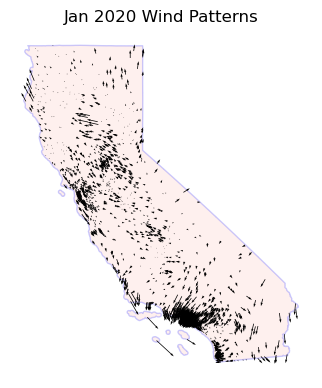

In [152]:

f,ax = plt.subplots(1,1, figsize=(4,4), 
    sharex=True, sharey=True, dpi=dpi)
f.tight_layout(pad=0.8)
ax.set_axis_off()
plt.title('Jan 2020 Wind Patterns',fontsize='large')
divider = make_axes_locatable(ax)
ux = ca_bound.to_crs(epsg=3857).plot(ax=ax, 
edgecolor='blue',    cmap='Pastel1', alpha = 0.2, 
legend=True, cax=None)

ux.quiver(jan_20['geometry'].x, jan_20['geometry'].y,jan_20['u'],jan_20['v'])
plt.show()

In [276]:
test_df

,lat,lon,u,v,wdir,wspd,geometry
0,37.465,-117.936,0.992558,0.124684,7.159901,1.000358,POINT (-13128575.466 4504121.513)
1,35.396,-116.322,0.088867,-0.147450,301.077087,0.172160,POINT (-12948905.808 4217827.033)
2,36.161,-116.139,-0.319009,-0.046086,188.220367,0.322321,POINT (-12928534.341 4322797.398)
3,35.957,-115.897,-0.106072,-0.459862,257.011322,0.471937,POINT (-12901595.024 4294706.250)
4,39.520,-120.032,0.707161,0.798291,48.464073,1.066463,POINT (-13361901.119 4796433.202)
5,33.959,-118.247,-0.667049,-1.111095,239.021393,1.295950,POINT (-13163195.828 4023298.056)
6,33.937,-118.229,-0.667049,-1.111095,239.021393,1.295950,POINT (-13161192.077 4020345.799)
7,33.938,-118.281,-0.667049,-1.111095,239.021393,1.295950,POINT (-13166980.691 4020479.976)
8,34.069,-118.338,-0.667049,-1.111095,239.021393,1.295950,POINT (-13173325.901 4038070.808)
9,34.055,-118.328,-0.667049,-1.111095,239.021393,1.295950,POINT (-13172212.707 4036189.575)


### Mapping x, y back to lon,lat

https://www.igismap.com/formula-to-find-bearing-or-heading-angle-between-two-points-latitude-longitude/

In [265]:
r_earth = 6378.1

In [133]:
test_df = gdf[['lat','lon','u','v','wdir','wspd','geometry']].head(10)

In [134]:
test_df

,lat,lon,u,v,wdir,wspd,geometry
0,37.465,-117.936,0.992558,0.124684,7.159901,1.000358,POINT (-13128575.466 4504121.513)
1,35.396,-116.322,0.088867,-0.147450,301.077087,0.172160,POINT (-12948905.808 4217827.033)
2,36.161,-116.139,-0.319009,-0.046086,188.220367,0.322321,POINT (-12928534.341 4322797.398)
3,35.957,-115.897,-0.106072,-0.459862,257.011322,0.471937,POINT (-12901595.024 4294706.250)
4,39.520,-120.032,0.707161,0.798291,48.464073,1.066463,POINT (-13361901.119 4796433.202)
5,33.959,-118.247,-0.667049,-1.111095,239.021393,1.295950,POINT (-13163195.828 4023298.056)
6,33.937,-118.229,-0.667049,-1.111095,239.021393,1.295950,POINT (-13161192.077 4020345.799)
7,33.938,-118.281,-0.667049,-1.111095,239.021393,1.295950,POINT (-13166980.691 4020479.976)
8,34.069,-118.338,-0.667049,-1.111095,239.021393,1.295950,POINT (-13173325.901 4038070.808)
9,34.055,-118.328,-0.667049,-1.111095,239.021393,1.295950,POINT (-13172212.707 4036189.575)


In [42]:
#Distance in Miles
test_df['geometry'][1].distance(test_df['geometry'][0]) * 0.000621371

210.0249748072942

In [309]:
test_df.iloc[2,:]['lat']

36.161

In [400]:
idx_a = 1
idx_b = 2
pa = test_df['geometry'][idx_a]
pb = test_df['geometry'][idx_b]

dist = lambda a,b : a.distance(b) * 0.000621371
dist(pa,pb)

pa_x = pa.x
pa_y = pa.y
pa_u = test_df.iloc[idx_a,:]['u']
pa_v = test_df.iloc[idx_a,:]['v']
pa_lat = test_df.iloc[idx_a,:]['lat']
pa_lon = test_df.iloc[idx_a,:]['lon']

pb_x = pb.x
pb_y = pb.y
pb_u = test_df.iloc[idx_b,:]['u']
pb_v = test_df.iloc[idx_b,:]['v']
pb_lat = test_df.iloc[idx_b,:]['lat']
pb_lon = test_df.iloc[idx_b,:]['lon']

d_X = np.cos(pa_lat) * np.cos((pa_lon - pb_lon))
d_Y = np.cos(pb_lat) * np.sin(pa_lat) - np.sin(pb_lat) * np.cos(pa_lat) * np.cos((pa_lon - pb_lon))
B_ba = np.arctan2(d_X,d_Y)*(180/np.pi)%360
B_ba

wdir_ba = np.arctan2(pb_u,pb_v)*(180/np.pi)%360

print(f"Wind is heading in direction {wdir_ba}")
print(f"Bearing from point b -> a is {B_ba}")

angle_diff = np.max([B_ba,wdir_ba]) - np.min([B_ba,wdir_ba])
if angle_diff >180:
    upwind_effect = (angle_diff)/360
else:
    upwind_effect = 1-(angle_diff)/360

print(f"Apparent effect of wind is {upwind_effect}")

Wind is heading in direction 261.77964521726784
Bearing from point b -> a is 223.97515740477408
Apparent effect of wind is 0.5833333333333333


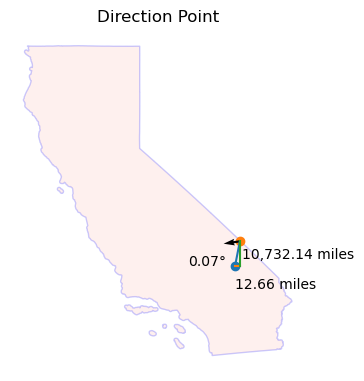

In [232]:
f,ax = plt.subplots(1,1, figsize=(4,4), 
    sharex=True, sharey=True, dpi=dpi)
f.tight_layout()
ax.set_axis_off()
plt.title('Direction Point',fontsize='large')
divider = make_axes_locatable(ax)
ux = ca_bound.to_crs(epsg=3857).plot(ax=ax, 
edgecolor='blue',    cmap='Pastel1', alpha = 0.2, 
legend=True, cax=None)

#Points of interest
ux.scatter(pa_x, pa_y)
ux.scatter(pb_x, pb_y)

#Triangle between point a and b
ux.plot((pa_x,pb_x),(pa_y,pb_y))
ux.plot((pa_x,pa_x+dx),(pa_y,pa_y))
ux.plot((pa_x+dx,pb_x),(pa_y,pb_y))

#Distances and apparent angle
ux.text(pa_x+1000,pa_y-100000,f'{dx* 0.000621371:,.02f} miles')
ux.text(pb_x+10000,pb_y-75000,f'{dy* 0.000621371:,.02f} miles')
ux.text(pa_x-200000, pa_y, f'{angle:,.02f}°')

#Wind Dir Overlay
ux.quiver(pb_x,pb_y,pb_u,pb_v)
plt.show()


In [233]:
angle = 360-np.degrees(np.arctan(dy/dx))
print(test_df['wdir'][2], angle)

188.22036743164065 270.06757865833214


Text(-12929534.341239998, 4332797.397620344, 'N')

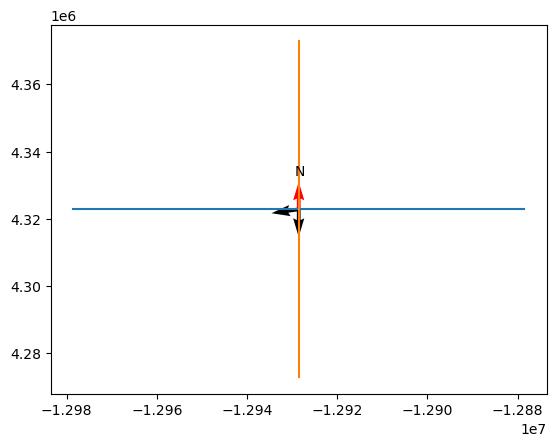

In [218]:
plt.quiver(pb_x,pb_y,pb_u,pb_v)
plt.quiver(pb_x,pb_y,-dx,-dy)
plt.quiver(pb_x,pb_y,0,1, color='r')
plt.plot([pb_x-50000,pb_x+50000], [pb_y, pb_y])
plt.plot([pb_x,pb_x], [pb_y+50000, pb_y-50000])
plt.text(pb_x-1000,pb_y+10000,'N')